In [15]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import warnings
warnings.simplefilter('ignore')

In [17]:
BATCH_SIZE = 20
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:/Users/Harshitha/Downloads/Extracted_Rice_Leaf_Disease_Images/Rice Leaf Disease Images',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [21]:
# Count the number of images (rows)
num_rows = 0
for batch in dataset:
    num_rows += batch[0].shape[0]  # Adds the number of images in each batch

# Count the number of classes (columns)
num_cols = len(dataset.class_names)

print(f"Number of rows (images): {num_rows}")
print(f"Number of columns (classes): {num_cols}")


Number of rows (images): 5932
Number of columns (classes): 4


In [23]:
from collections import Counter

label_counts = Counter()
for _, labels in dataset:
    label_counts.update(labels.numpy())

for class_index, count in label_counts.items():
    print(f"{dataset.class_names[class_index]}: {count} images")


Blast: 1440 images
Bacterialblight: 1584 images
Tungro: 1308 images
Brownspot: 1600 images


In [25]:
for batch, labels in dataset:
    if batch.shape[0] != len(labels):  # Checks if the batch and label counts match
        print("Mismatch found in batch size and label count")
    if any(label is None for label in labels):  # Checks for any None labels
        print("Found a None label in the dataset")
        
print("No null and no inconsistent entries found in the dataset")


No null and no inconsistent entries found in the dataset


In [27]:
for images, _ in dataset.take(1):
    print(f"Image shape: {images[0].shape}")


Image shape: (128, 128, 3)


In [29]:
consistent_shape = True
expected_shape = None

for images, _ in dataset:
    for image in images:
        if expected_shape is None:
            expected_shape = image.shape  # Set the expected shape from the first image
        if image.shape != expected_shape:
            print(f"Inconsistent shape found: {image.shape}")
            consistent_shape = False
            break
    if not consistent_shape:
        break

if consistent_shape:
    print(f"All images have a consistent shape: {expected_shape}")
else:
    print("There are images with inconsistent shapes.")


All images have a consistent shape: (128, 128, 3)


In [31]:
import numpy as np

pixel_values = []
for images, _ in dataset.take(10):  # Adjust the number of batches for faster calculation
    pixel_values.extend(images.numpy().ravel())
print("Mean pixel value:", np.mean(pixel_values))
print("Standard deviation of pixel values:", np.std(pixel_values))


Mean pixel value: 109.81453
Standard deviation of pixel values: 53.04508


In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

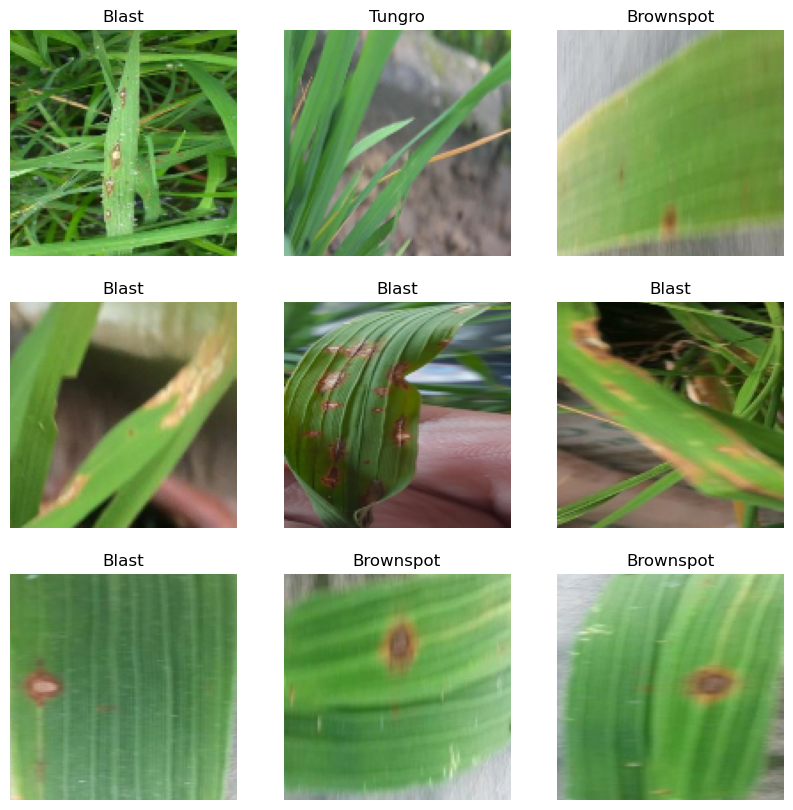

In [39]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [40]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(65, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(35, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(64, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(6)
    ]
)

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=7,
)

Epoch 1/7
190/237 ━━━━━━━━━━━━━━━━━━━━ 4:56 6s/step - accuracy: 0.5129 - loss: 1.1341

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
EPOCHS=7
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

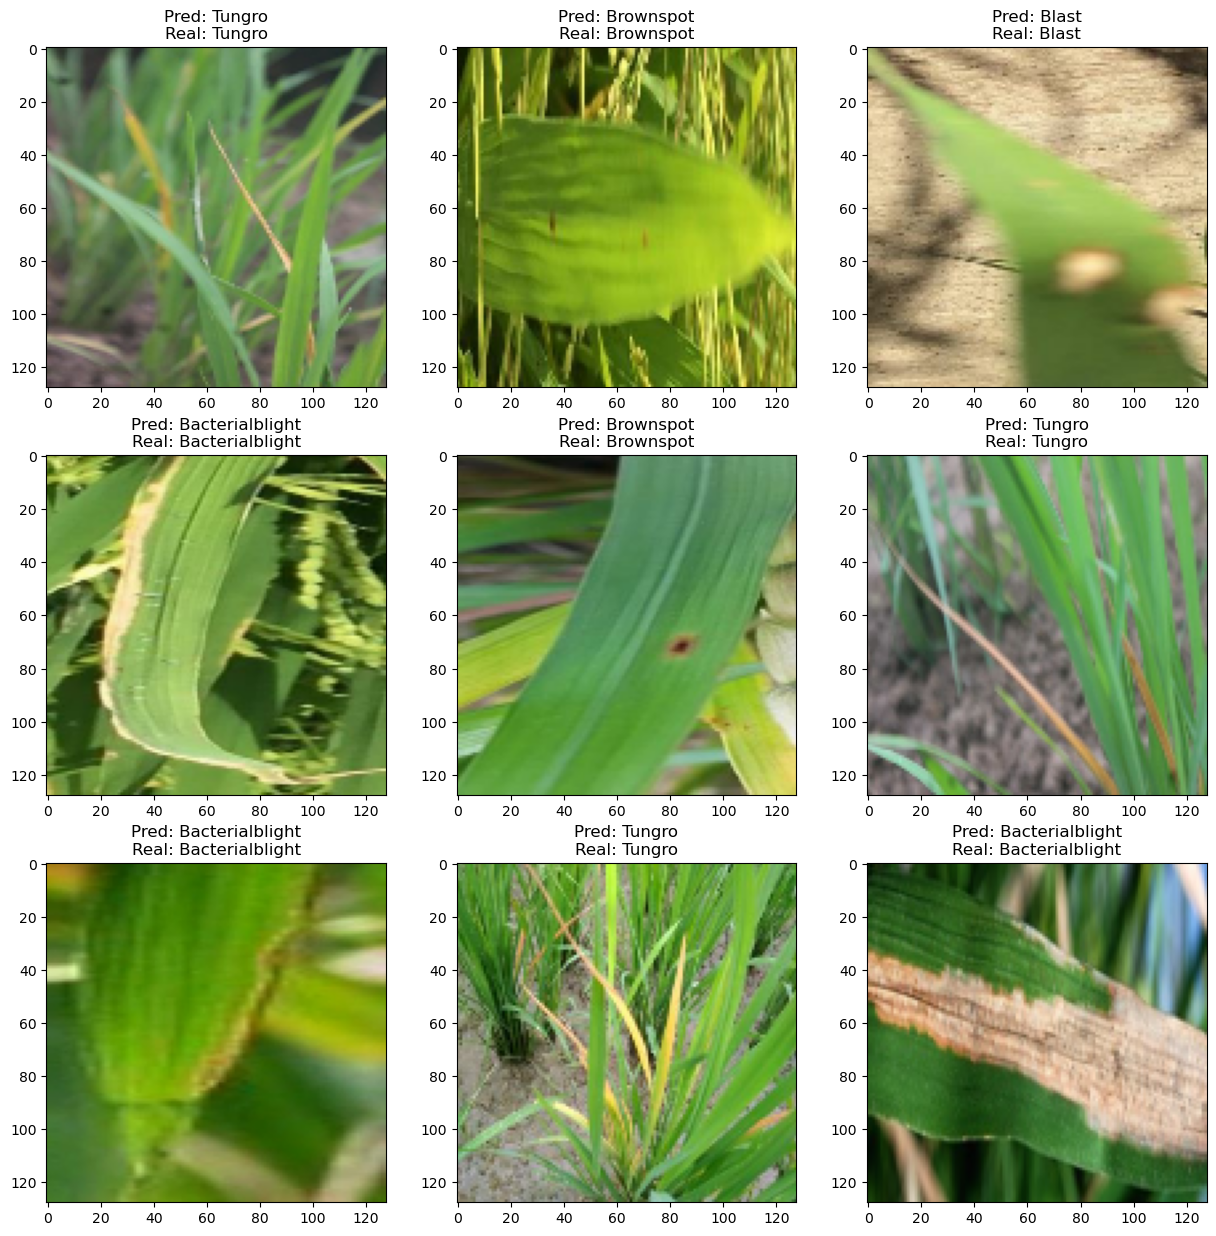

In [25]:
import numpy

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    classifications = model(images)
  #print(classifications)

    for i in range(9):
               
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = numpy.argmax(classifications[i])
        #print(index)
        plt.title("Pred: " + class_names[index] + "\nReal: " + class_names[labels[i]])

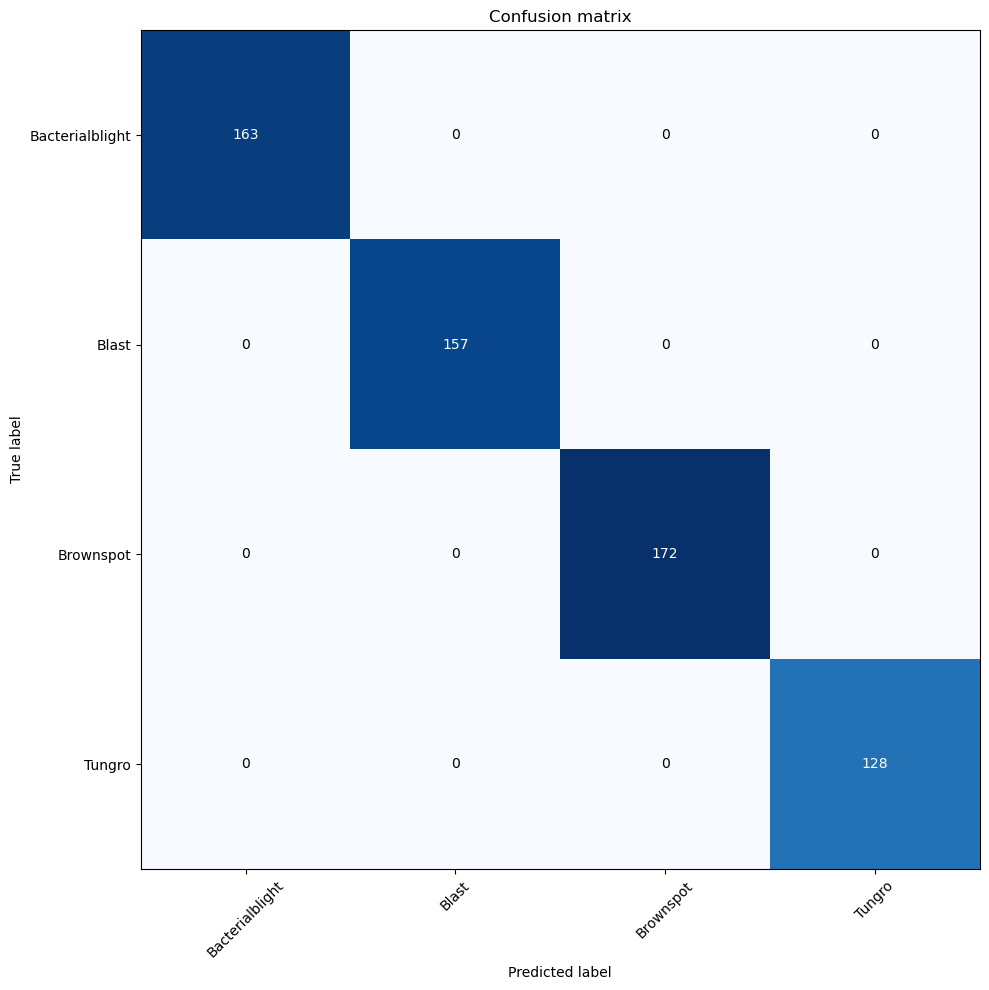

In [26]:
all_predicted_labels = []
all_actual_labels = []

for images, labels in test_ds:
    classifications = model(images)
    predicted_labels = [np.argmax(classification) for classification in classifications.numpy()]
    all_predicted_labels.extend(predicted_labels)
    all_actual_labels.extend(labels.numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predicted_labels)

# Plot confusion matrix with numbers
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
#plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')


thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import classification_report

report = classification_report(all_actual_labels, all_predicted_labels, target_names=class_names)


print(report)

                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       163
          Blast       1.00      1.00      1.00       157
      Brownspot       1.00      1.00      1.00       172
         Tungro       1.00      1.00      1.00       128

       accuracy                           1.00       620
      macro avg       1.00      1.00      1.00       620
   weighted avg       1.00      1.00      1.00       620



In [ ]:
#MobileNetV2 base model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
EPOCHS = 5
DATASET_PATH = r'C:/Users/Harshitha/Downloads/Extracted_Rice_Leaf_Disease_Images/Rice Leaf Disease Images'

In [4]:
# Load and preprocess the dataset
dataset = image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = dataset.class_names


Found 5932 files belonging to 4 classes.


In [5]:
# Split the dataset
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)

In [6]:
# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

from tensorflow.keras.applications import MobileNetV2


# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy}")

# Display a summary of the model
model.summary()

# Generate classification report and confusion matrix
all_predicted_labels = []
all_actual_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    all_predicted_labels.extend(predicted_labels)
    all_actual_labels.extend(labels.numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
report = classification_report(all_actual_labels, all_predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 151s 953ms/step - accuracy: 0.5907 - loss: 3.4332 - val_accuracy: 0.9549 - val_loss: 0.2835
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9241 - loss: 0.4508 - val_accuracy: 0.9809 - val_loss: 0.1035
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 955ms/step - accuracy: 0.9680 - loss: 0.1000 - val_accuracy: 0.9861 - val_loss: 0.0407
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 145s 977ms/step - accuracy: 0.9807 - loss: 0.0712 - val_accuracy: 0.9896 - val_loss: 0.0355
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 145s 979ms/step - accuracy: 0.9819 - loss: 0.0488 - val_accuracy: 0.9913 - val_loss: 0.0249
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 738ms/step - accuracy: 0.9961 - loss: 0.0113
Test accuracy: 0.9951612949371338


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,243,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,990,482 (68.63 MB)

 Trainable params: 5,244,164 (20.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,488,334 (40.01 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confusion Matrix:
 [[153   0   0   0]
 [  2 142   2   0]
 [  0   0 197   0]
 [  0   0   0 124]]
Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.99      1.00      0.99  

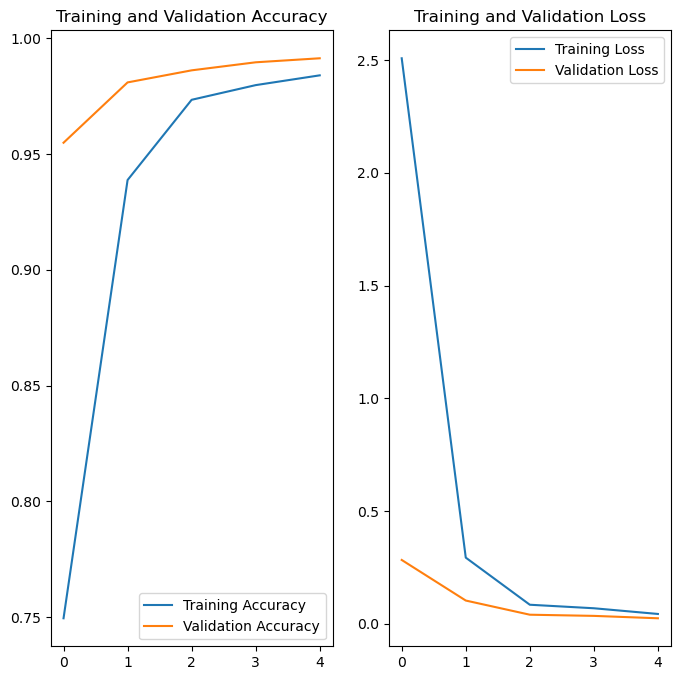

In [8]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


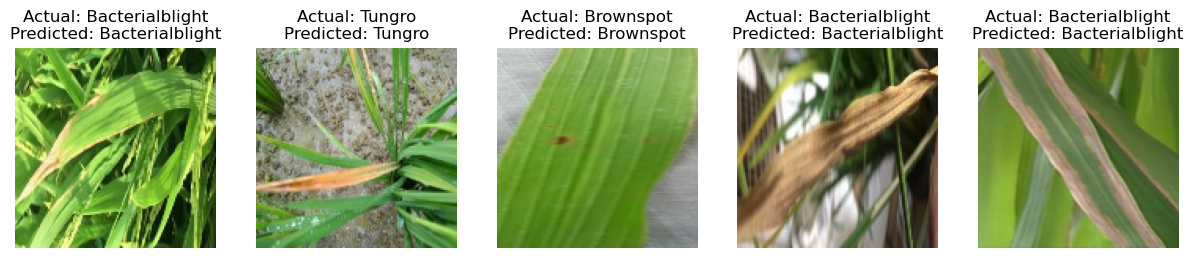

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display sample images with actual and predicted labels
def display_actual_vs_predicted(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))

    # Fetch one batch of data from the test dataset
    for images, labels in dataset.take(1):
        predictions = model.predict(images)  # Predict on the batch
        predicted_labels = np.argmax(predictions, axis=1)
        
        # Display a sample of images with their actual and predicted labels
        for i in range(min(num_images, len(images))):
            plt.subplot(1, num_images, i + 1)
            img = images[i].numpy()  # Convert to numpy array
            img = np.clip(img * 255, 0, 255).astype('uint8')  # Convert back to original pixel range
            plt.imshow(img)
            actual_label = class_names[labels[i].numpy()]
            predicted_label = class_names[predicted_labels[i]]
            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
            plt.axis('off')
    
    plt.show()

# Display sample of actual vs predicted images from the test dataset
display_actual_vs_predicted(model, test_ds, class_names, num_images=5)
